## See [Tests](#Tests)

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../"))

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from scipy.constants import mu_0
from netCDF4 import Dataset
import desc.io

from desc.basis import PowerSeries
from desc.compute import compute_rotational_transform, data_index
from desc.equilibrium import Equilibrium
from desc.grid import ConcentricGrid, LinearGrid, QuadratureGrid
import desc.io
from desc.plotting import plot_comparison
from desc.profiles import PowerSeriesProfile
from desc.transform import Transform

DESC version 0.5.1+118.g71ace73.dirty, using JAX backend, jax version=0.2.25, jaxlib version=0.1.76, dtype=float64
Using device: CPU, with 1.82 GB available memory


## Visualizing grids

In [7]:
def print_grid(grid, stop=None, quantity=None):
    """
    Parameters
    ----------
    grid
        Prints nodes and spacing.
    stop : int
        Max number of nodes to print. Defaults to entire grid.
    quantity : ndarray
        A quantity to print alongside the grid. i.e. data["iota"]
    """
    assert (
        grid.num_nodes // grid.num_zeta
        == np.where(~np.isclose(grid.nodes[:, 2], 0))[0][0]
    )
    print(grid.L, grid.M, grid.N, grid.NFP, grid.sym, grid.node_pattern)
    print(grid.num_rho, grid.num_theta, grid.num_zeta)
    print("nodes", "             ", "spacing")
    if stop is None:
        stop = grid.num_nodes
    if quantity is None:
        for i, e in enumerate(zip(grid.nodes, grid.spacing)):
            a, b = e
            print(a, b)
            if i > stop:
                break
    else:
        for i, e in enumerate(zip(grid.nodes, grid.spacing, quantity)):
            a, b, c = e
            print(a, b, c)
            if i > stop:
                break


def get_grid(eq, use_quad=True):
    """
    Parameters
    ----------
    eq : Equilibrium
        The equilibrium.
    use_quad : bool
        True to use QuadratureGrid; False to use ConcentricGrid

    Returns
    -------
    ConcentricGrid or QuadratureGrid
        Grid with resolution used by the given equilibrium.
    """
    if use_quad:
        return QuadratureGrid(
            L=eq.L_grid,
            M=eq.M_grid,
            N=eq.N_grid,
            NFP=1,
        )
    else:
        ConcentricGrid(
            L=eq.L_grid,
            M=eq.M_grid,
            N=eq.N_grid,
            NFP=1,
            sym=False,
        )


def random_grid(NFP=None, sym=None):
    """
    NFP: int
        Number of field periods.
    sym: bool
        Stellarator symmetry.

    Returns
    -------
    ConcentricGrid
        Randomized grid.
    """
    rng = np.random.default_rng()
    L = rng.integers(low=1, high=10)
    M = rng.integers(low=1, high=10)
    N = rng.integers(low=1, high=10)
    if NFP is None:
        NFP = rng.integers(low=1, high=10)
    if sym is None:
        sym = True if rng.integers(2) > 0 else False
    return ConcentricGrid(L=L, N=N, M=M, NFP=NFP, sym=sym)

In [13]:
print_grid(random_grid(), stop=20)

9 9 4 8 False jacobi
5 49 9
nodes               spacing
[0.09853509 0.         0.        ] [0.40307081 4.1887902  0.17453293]
[0.09853509 2.0943951  0.        ] [0.40307081 4.1887902  0.17453293]
[0.09853509 4.1887902  0.        ] [0.40307081 4.1887902  0.17453293]
[0.30453573 0.         0.        ] [0.4634901  1.7951958  0.17453293]
[0.30453573 0.8975979  0.        ] [0.4634901  1.7951958  0.17453293]
[0.30453573 1.7951958  0.        ] [0.4634901  1.7951958  0.17453293]
[0.30453573 2.6927937  0.        ] [0.4634901  1.7951958  0.17453293]
[0.30453573 3.5903916  0.        ] [0.4634901  1.7951958  0.17453293]
[0.30453573 4.48798951 0.        ] [0.4634901  1.7951958  0.17453293]
[0.30453573 5.38558741 0.        ] [0.4634901  1.7951958  0.17453293]
[0.56202519 0.         0.        ] [0.49745086 1.14239733 0.17453293]
[0.56202519 0.57119866 0.        ] [0.49745086 1.14239733 0.17453293]
[0.56202519 1.14239733 0.        ] [0.49745086 1.14239733 0.17453293]
[0.56202519 1.71359599 0.        ]

## Grabbing VMEC/DESC outputs

In [3]:
def get_vmec_data(name, quantity):
    """
    Parameters
    ----------
    name : str
        Name of the equilibrium.
    quantity: str
        Name of the quantity to return.

    Returns
    -------
    :rtype: (ndarray, ndarray)
    rho : ndarray
        Radial coordinate.
    quantity : ndarray
        Variable from VMEC output solved in fix current mode.
    """
    f = Dataset("examples/edu-vmec-current/wout_" + name + ".nc")
    rho = np.sqrt(f.variables["phi"] / np.array(f.variables["phi"])[-1])
    quantity = np.asarray(f.variables[quantity])
    f.close()
    return rho, quantity


def get_desc_eq(name, fix_current=False):
    """
    Parameters
    ----------
    name : str
        Name of the equilibrium.
    fix_current : bool
        True to use an equilibrium solved in fix current mode.
        False to use one solved in fix iota mode.

    Returns
    -------
    Equilibrium
        DESC equilibrium.
    """
    if fix_current:
        file = "../examples/DESC/current/" + name + "_output.h5"
    else:
        file = "../examples/DESC/" + name + "_output.h5"
    return desc.io.load(file)[-1]

## Plot functions

In [4]:
def plot_overlay(x, y1, label_1, titles, symlog=True, y2=None, label_2=None):
    """
    Parameters
    ----------
    x : ndarray
        x data
    y1, y2 : ndarray or tuple[ndarray]
        y data. will make multiple plots if y.ndim > 1
    label_1, label_2 : str
        y1, y2 plot labels
    titles : str or tuple[str]
        plot titles
    symlog : bool
        True to use a symmetric log scale; False to use linear scale.
    """
    # makes iteration easier
    if not isinstance(titles, tuple):
        titles = (titles,)
    y1 = np.atleast_2d(y1)
    if y2 is not None:
        y2 = np.atleast_2d(y2)
        assert y1.size == y2.size

    fig, ax = plt.subplots(ncols=y1.shape[0], figsize=(y1.shape[0] * 8, 5))
    ax = np.atleast_1d(ax)

    for i in range(y1.shape[0]):
        ax[i].plot(x, y1[i, :], label=label_1)
        ax[i].scatter(x, y1[i, :], s=9)
        if y2 is not None:
            ax[i].plot(x, y2[i, :], label=label_2)
            ax[i].scatter(x, y2[i, :], s=3)
        ax[i].set(
            yscale="symlog" if symlog else "linear",
            xlabel=r"$\rho$",
            title=titles[i],
            facecolor="white",
        )
        ax[i].grid()
        ax[i].legend(fontsize="x-small")

## Fitting output current to power series
This is used to set the fixed current profile coefficients on the fixed-current input files.
Because we know `compute_rotational_transform()` works properly, solving an equilibrium with the profiles below should produce similar equilibrium to the original fixed-iota equilibria.

/home/kaya/Documents/edu/pton/plasma/DESC/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_current' was not loaded.
  warnings.warn(


DSHAPE
[      0.         -438474.59377869  175194.056811     71469.4336739
  -33076.87769384]


NameError: name 'get_grid' is not defined

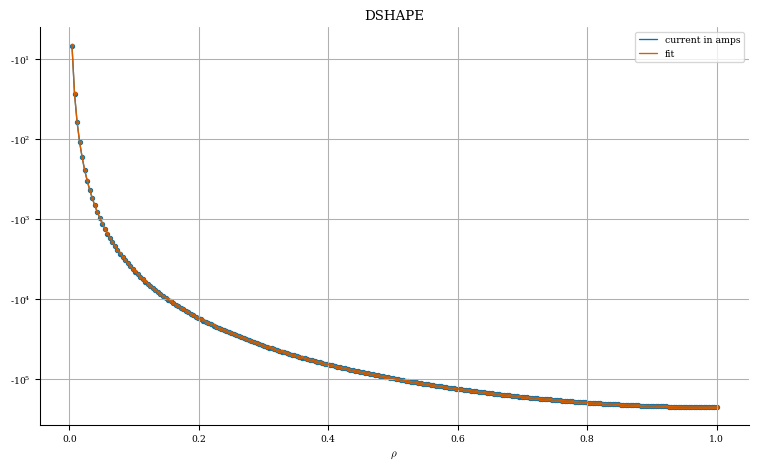

In [5]:
def get_toroidal_current(eq, rho):
    """
    Parameters
    ----------
    eq : Equilibrium
        The equilibrium.
    rho : ndarray
        The rho values to compute current at.

    Returns
    -------
    current : ndarray
        The toroidal current in tesla-meters at each unique rho surface of the given equilibrium.
    """
    current = np.empty_like(rho)
    for i, r in enumerate(rho):
        data = eq.compute("I", grid=LinearGrid(M=12, N=12, rho=np.atleast_1d(r)))
        current[i] = data["I"]
    assert np.isfinite(current).all()
    return current


def get_current_fit(name, L=8, sym="even"):
    """
    Fits a power series to the resulting current of a fixed iota equilibrium.
    Plots an overlay of this fit.
    Prints the coefficients of this power series.

    Parameters
    ----------
    name : str
        Name of the equilibrium.
    L : int
        The highest order on power series fit.
    sym
        Default "even" fits power series with even powers.
        False as a bool fits power series with even and odd powers.

    Returns
    -------
    PowerSeriesProfile
        Toroidal current power series profile.
    """
    rho = np.linspace(1 / 256, 1, 256)
    eq = get_desc_eq(name)

    # computed on linear grid with M=10, N=10
    current_amps = 2 * np.pi / mu_0 * get_toroidal_current(eq, rho)
    basis = PowerSeries(L=L, sym=sym)
    trans = Transform(LinearGrid(rho=rho), basis, build_pinv=True)
    coefficients = np.copy(trans.fit(current_amps))
    coefficients[0] = 0

    plot_overlay(
        x=rho,
        y1=current_amps,
        label_1="current in amps",
        y2=trans.transform(coefficients),
        label_2="fit",
        titles=name,
    )
    print(name)
    print(coefficients)
    return PowerSeriesProfile(
        params=coefficients, modes=basis.modes[:, 0], grid=get_grid(eq)
    )


dshape_fit = get_current_fit("DSHAPE")
heliotron_fit = get_current_fit("HELIOTRON")
solovev_fit = get_current_fit("SOLOVEV")
estell_fit = get_current_fit("ESTELL", L=24)
wistell_fit = get_current_fit("WISTELL-A", L=24)
# shouldn't the enclosed current have increasing magnitude?

# Tests
* Bootstrap method
    - This gives the same result for iota and confirms that the `compute_rotational_transform()` function is correct.
    - The first point near the origin is weird, but this issue vanishes on Quadrature grids.
* compare fix iota to fix current solves
    - Works on DShape and Solovev. The rotational transform from the fixed-iota equilibrium is replicated.
    - Other inputs don't have nested surfaces. This shows that, while the `compute_rotational_transform()` function is correct, DESC may not converge back to the fixed-iota equilibrium. I'll need help fixing this.
* we could compare to VMEC, but VMEC actually does terribly on fixed-current equilibrium solves. Have to do guesswork on VMEC trying to get it to converge, which adds more unknown variables to testing. Probably better to use above two testing methods, then fiddle around with VMEC.

In [ ]:
def compute_iota_bootstrap(eq, current):
    """
    Compute iota using the current from data["I"] of an equilibrium solved in fix-iota mode as the current constraint.
    I called this the bootstrap method.

    Parameters
    ----------
    eq : Equilibrium
        The equilibrium.
    current : PowerSeriesProfile
        Toroidal current profile.

    Returns
    -------
    data : dict
        Dictionary of ndarray, shape(num_nodes,) of rotational transform profile.
        Keys are of the form 'X_y' meaning the derivative of X wrt y.
    """
    grid = current.grid
    R_transform = Transform(
        grid, eq.R_basis, derivs=data_index["iota_rr"]["R_derivs"], build=True
    )
    Z_transform = Transform(
        grid, eq.Z_basis, derivs=data_index["iota_rr"]["R_derivs"], build=True
    )
    L_transform = Transform(
        grid, eq.L_basis, derivs=data_index["iota_rr"]["L_derivs"], build=True
    )
    return compute_rotational_transform(
        eq.R_lmn,
        eq.Z_lmn,
        eq.L_lmn,
        i_l=None,
        c_l=current.params,
        Psi=eq.Psi,
        R_transform=R_transform,
        Z_transform=Z_transform,
        L_transform=L_transform,
        iota=None,
        current=current,
    )

/home/kaya/Documents/edu/pton/plasma/DESC/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_current' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_current' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_current' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_current' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_current' was not loaded.
  warnings.warn(


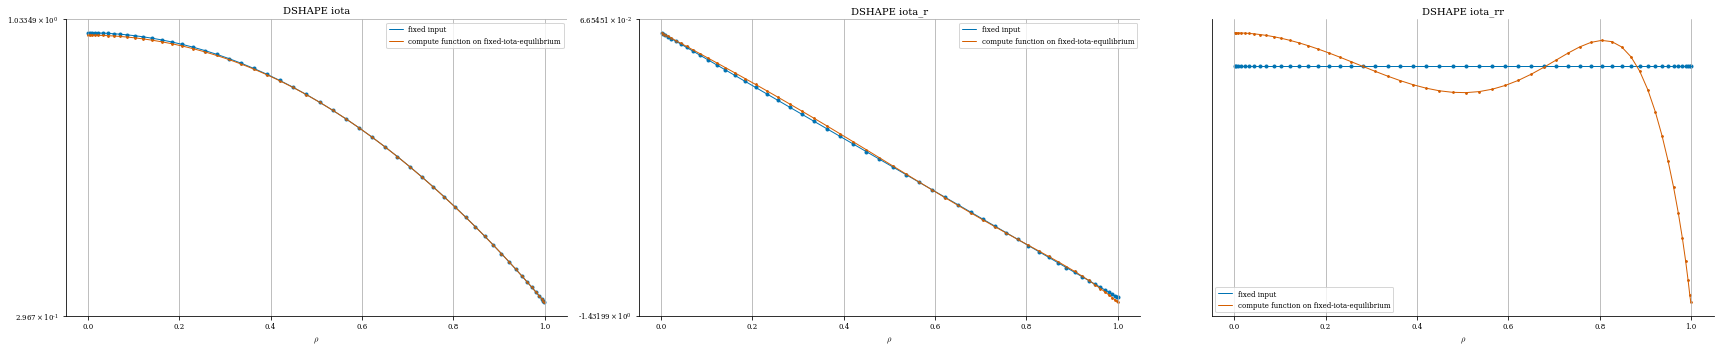

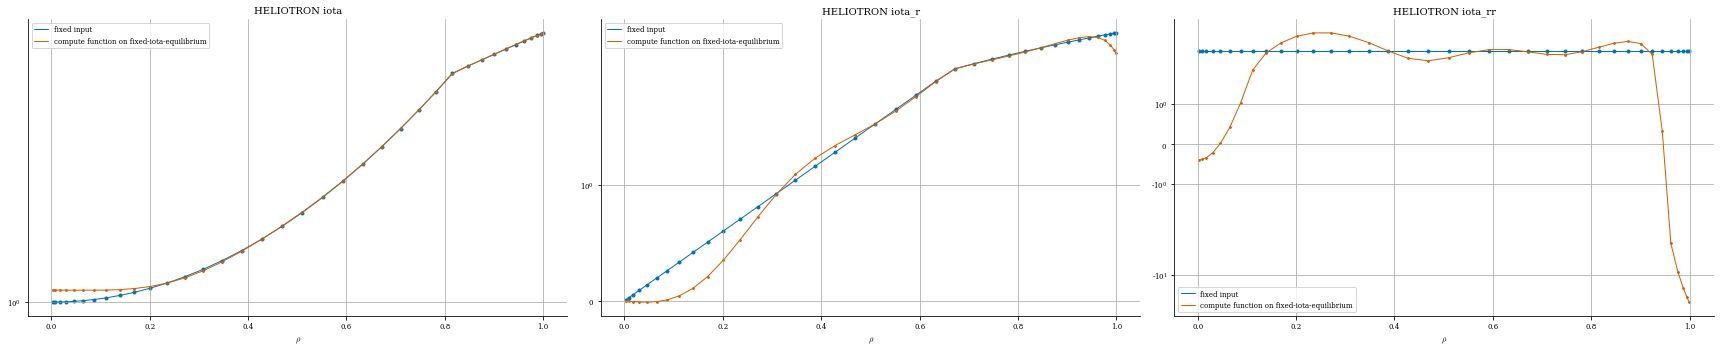

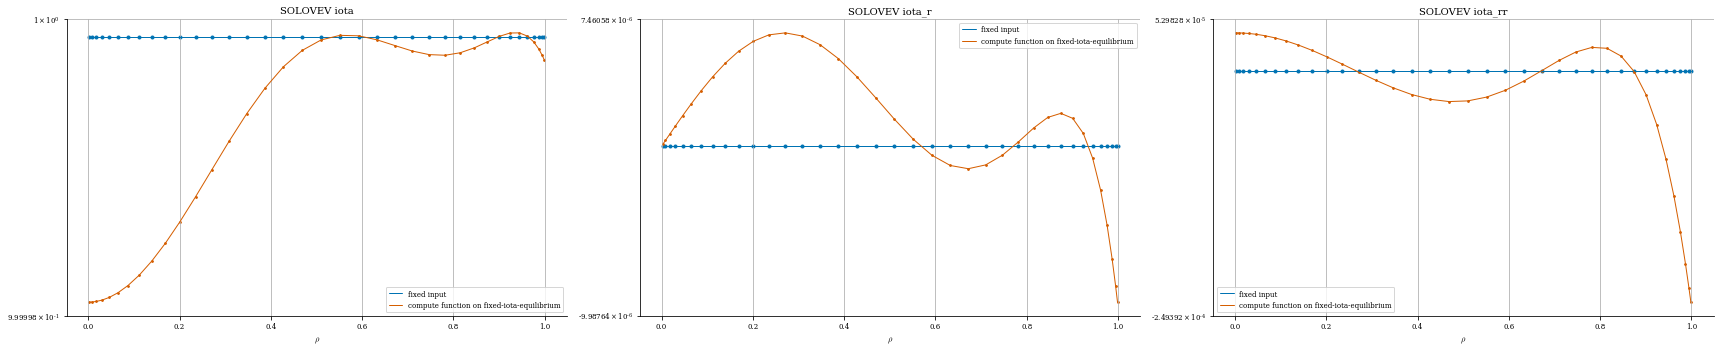

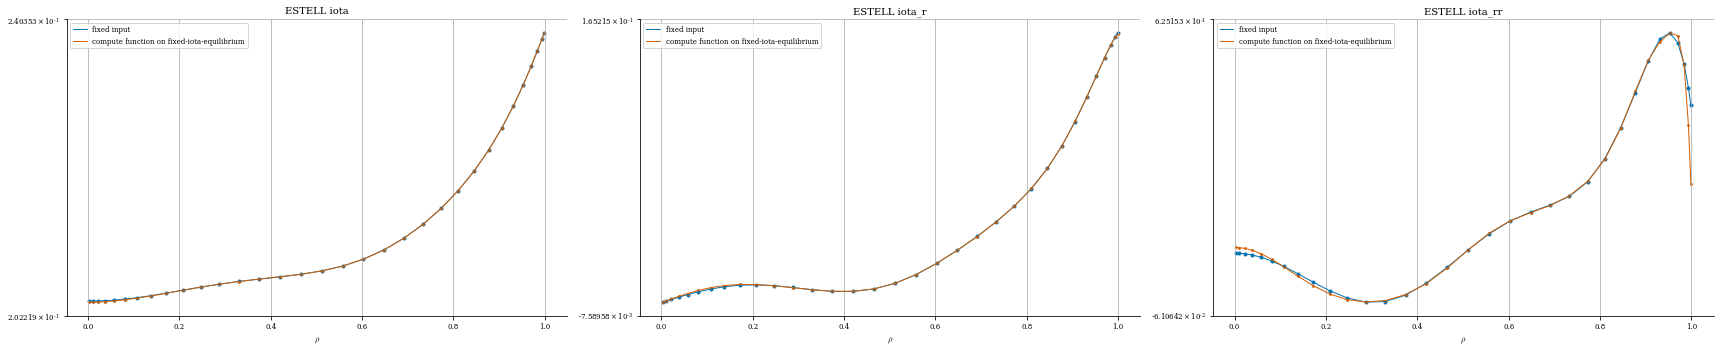

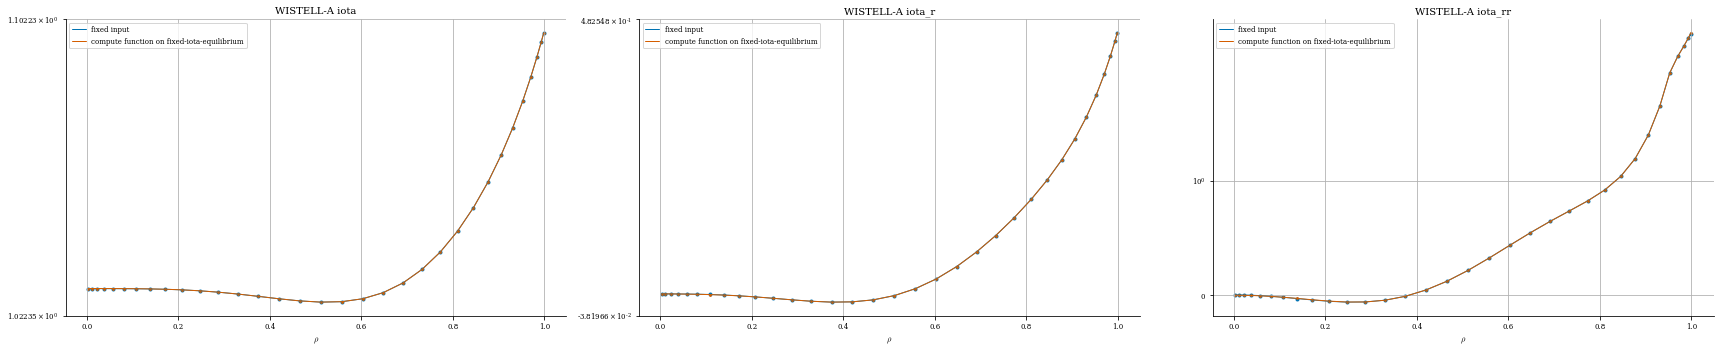

In [18]:
def compare_iota_bootstrap(name: str, current: PowerSeriesProfile):
    eq = get_desc_eq(name)

    grid = current.grid
    m = grid.unique_rho_indices
    data_1 = eq.compute("iota_rr", grid=grid)
    data_2 = compute_iota_bootstrap(eq, current)

    plot_overlay(
        x=grid.nodes[m, 0],
        y1=(data_1["iota"][m], data_1["iota_r"][m], data_1["iota_rr"][m]),
        label_1="fixed input",
        y2=(data_2["iota"][m], data_2["iota_r"][m], data_2["iota_rr"][m]),
        label_2="compute function on fixed-iota-equilibrium",
        titles=tuple(name + " " + s for s in ("iota", "iota_r", "iota_rr")),
    )


compare_iota_bootstrap("DSHAPE", dshape_fit)
compare_iota_bootstrap("HELIOTRON", heliotron_fit)
compare_iota_bootstrap("SOLOVEV", solovev_fit)
compare_iota_bootstrap("ESTELL", estell_fit)
compare_iota_bootstrap("WISTELL-A", wistell_fit)

## Compare iotas on equilibrium solved using fixed iota vs fixed current

/home/kaya/Documents/edu/pton/plasma/DESC/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_current' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_iota' was not loaded.
  warnings.warn(


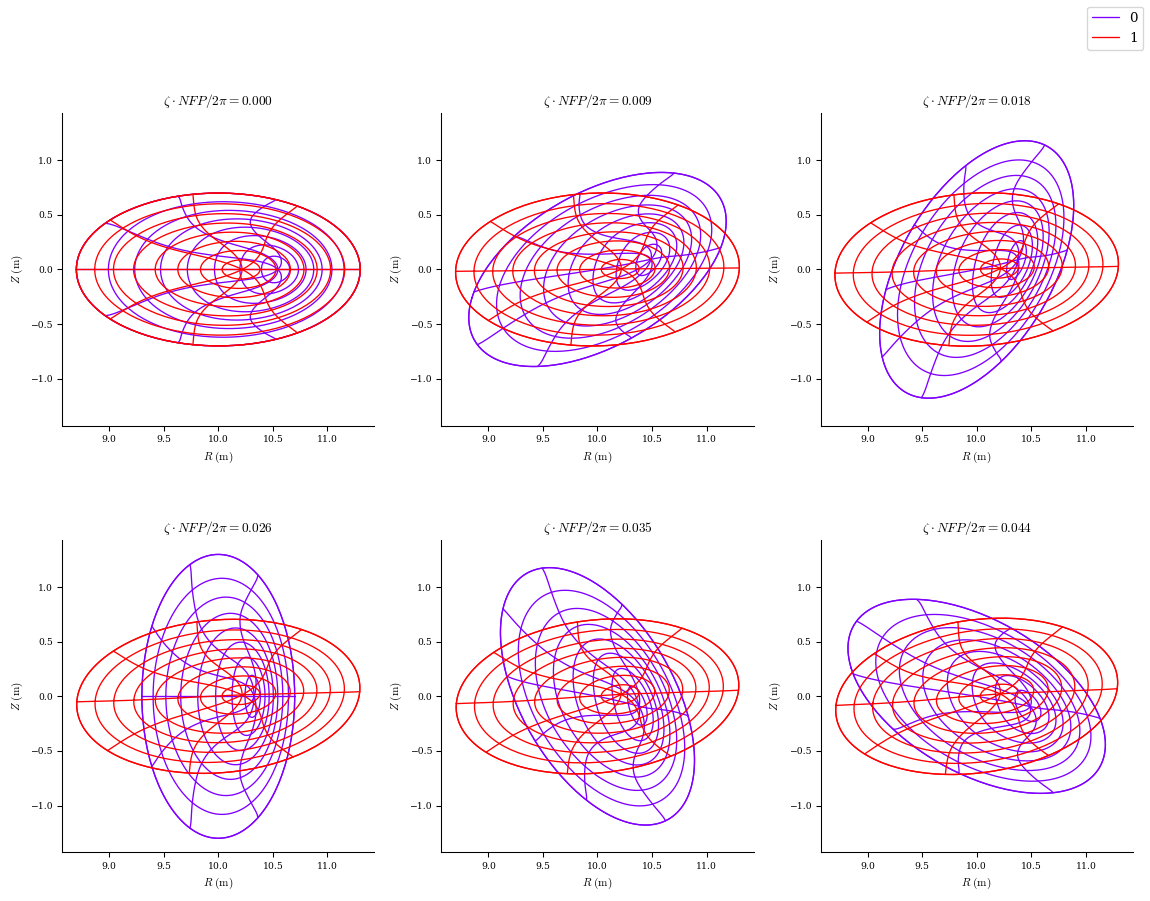

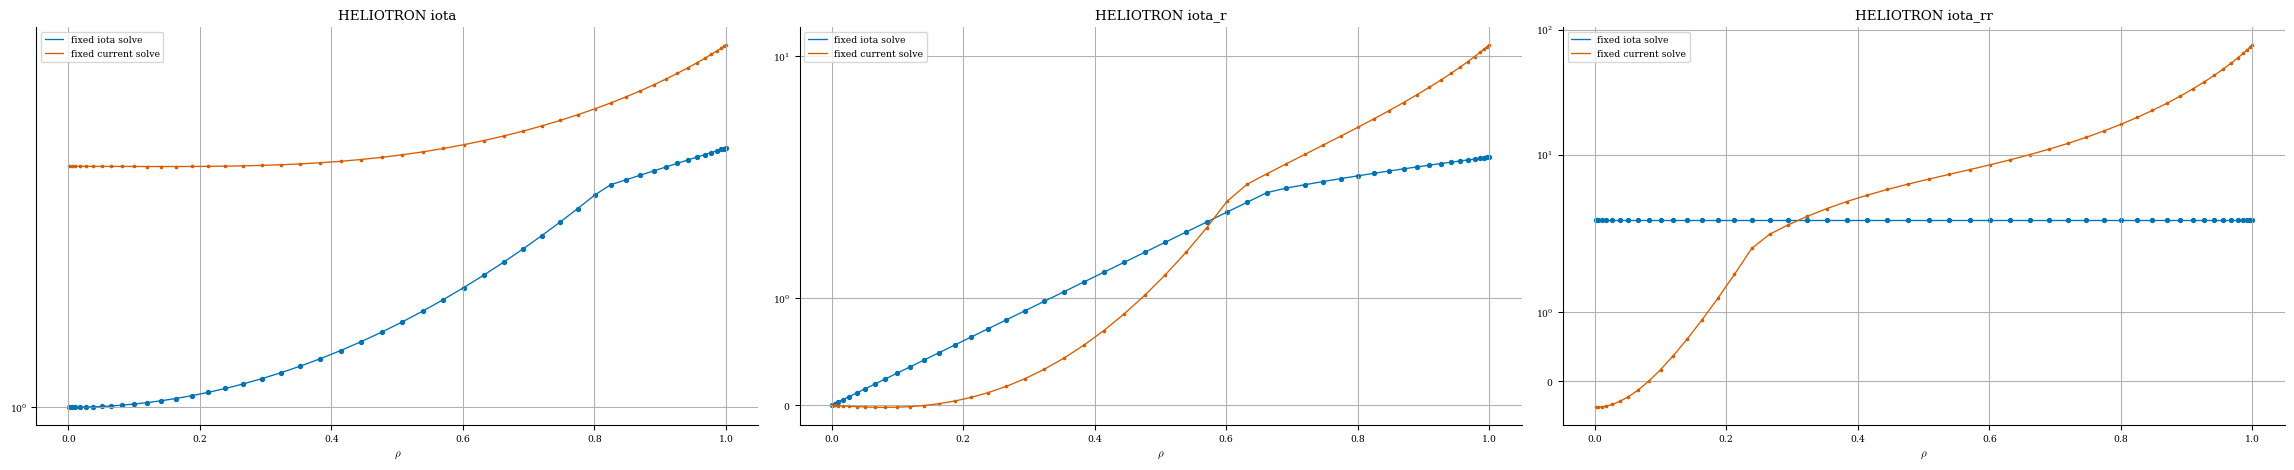

In [8]:
def compare_iota_fix_current_solve(name: str):
    eq_1 = get_desc_eq(name)
    eq_2 = get_desc_eq(name + "_no_perturb", fix_current=True)
    plot_comparison([eq_1, eq_2])

    grid = get_grid(eq_2)
    m = grid.unique_rho_indices
    data_1 = eq_1.compute("iota_rr", grid=grid)
    data_2 = eq_2.compute("iota_rr", grid=grid)

    plot_overlay(
        x=grid.nodes[m, 0],
        y1=(data_1["iota"][m], data_1["iota_r"][m], data_1["iota_rr"][m]),
        label_1="fixed iota solve",
        y2=(data_2["iota"][m], data_2["iota_r"][m], data_2["iota_rr"][m]),
        label_2="fixed current solve",
        titles=tuple(name + " " + s for s in ("iota", "iota_r", "iota_rr")),
    )


# compare_iota_fix_current_solve("DSHAPE")
compare_iota_fix_current_solve("HELIOTRON")
# compare_iota_fix_current_solve("SOLOVEV")
# compare_iota_fix_current_solve("ESTELL")
# compare_iota_fix_current_solve("WISTELL-A")